In [294]:
## Imports
import pandas as pd
import numpy as np
import difflib
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics  
from sklearn_evaluation import plot

In [295]:
# Read the 3 csv files and translate the column names from German to English via google translate and Kaggle notes.
# https://www.kaggle.com/datasets/kmader/dogs-of-zurich?resource=download&select=zuordnungstabellehunderassehundetyp.csv
df_2015 = pd.read_csv('20151001hundehalter.csv')
df_2016 = pd.read_csv('20160307hundehalter.csv')
df_2017 = pd.read_csv('20170308hundehalter.csv')

df_2015['record_year'] = 2015
df_2016['record_year'] = 2016
df_2017['record_year'] = 2017

df_15_17 = pd.concat([df_2015, df_2016, df_2017], axis=0)
print(df_15_17.columns, df_15_17.shape)


Index(['HALTER_ID', 'ALTER', 'GESCHLECHT', 'STADTKREIS', 'STADTQUARTIER',
       'RASSE1', 'RASSE1_MISCHLING', 'RASSE2', 'RASSE2_MISCHLING', 'RASSENTYP',
       'GEBURTSJAHR_HUND', 'GESCHLECHT_HUND', 'HUNDEFARBE', 'record_year'],
      dtype='object') (21065, 14)


In [296]:
# German to English translations for column names
df_15_17.columns = ['OWNER_ID', 'OWNER_AGE', 'OWNER_GENDER', 'CITY_DISTRICT', 'CITY_QUARTER',
    'BREED1', 'BREED1_HYBRID', 'BREED2', 'BREED2_HYBRID', 'BREED_TYPE',
    'DOG_BIRTH_YEAR', 'DOG_GENDER', 'DOG_COLOR', 'record_year']

# View updated column names
df_15_17.head()

,OWNER_ID,OWNER_AGE,OWNER_GENDER,CITY_DISTRICT,CITY_QUARTER,BREED1,BREED1_HYBRID,BREED2,BREED2_HYBRID,BREED_TYPE,DOG_BIRTH_YEAR,DOG_GENDER,DOG_COLOR,record_year
0,126,51-60,m,9.0,92.0,Welsh Terrier,NaN,NaN,NaN,K,2011,w,schwarz/braun,2015
1,574,61-70,w,2.0,23.0,Cairn Terrier,NaN,NaN,NaN,K,2002,w,brindle,2015
2,695,41-50,m,6.0,63.0,Labrador Retriever,NaN,NaN,NaN,I,2012,w,braun,2015
3,893,61-70,w,7.0,71.0,Mittelschnauzer,NaN,NaN,NaN,I,2010,w,schwarz,2015
4,1177,51-60,m,10.0,102.0,Shih Tzu,NaN,NaN,NaN,K,2011,m,schwarz/weiss,2015


2. Let's look closer at columns and do some data cleaning.

In [297]:
# For brevity, these text columns had some nan's that will be filled with 'Not listed"
df_15_17['BREED1_HYBRID'] = df_15_17['BREED1_HYBRID'].fillna('not_listed')
df_15_17['BREED_TYPE'] = df_15_17['BREED_TYPE'].fillna('not_listed')
df_15_17['BREED1'] = df_15_17['BREED1'].fillna('not_listed')
df_15_17['BREED2'] = df_15_17['BREED2'].fillna('not_listed')
df_15_17['DOG_COLOR'] = df_15_17['DOG_COLOR'].fillna('not_listed')

In [298]:
print(df_15_17['OWNER_AGE'].unique())
print(df_15_17['OWNER_GENDER'].unique())

# Owner age is of key interest so let's drop two nan rows.
df_15_17.dropna(subset=['OWNER_AGE'], inplace=True)

['51-60' '61-70' '41-50' '71-80' '31-40' '81-90' '21-30' '91-100' nan
 '11-20']
['m' 'w']


In [299]:
print(df_15_17['CITY_DISTRICT'].unique())
print(df_15_17['CITY_QUARTER'].unique())

# Urban circle and city quarter fill nan with not_listed, cast to string.
df_15_17['CITY_DISTRICT'] = df_15_17['CITY_DISTRICT'].fillna('not_listed')
df_15_17['CITY_QUARTER'] = df_15_17['CITY_QUARTER'].fillna('not_listed')
df_15_17 = df_15_17.astype({'CITY_DISTRICT':'str','CITY_QUARTER':'str'})

[ 9.  2.  6.  7. 10.  3. 11.  8.  5.  4. nan 12.  1.]
[ 92.  23.  63.  71. 102.  34. 111.  21.  81.  91.  74.  52.  42.  82.
  51.  72. 119. 101.  61.  nan 122.  41.  33.  31.  24.  73. 121.  44.
 123.  83. 115.  14.  11.  13.   4.  12.   6.]


In [300]:
print(df_15_17['BREED2_HYBRID'].unique())
# Breed 2 Hybrid column is only nan, so let's drop it.
df_15_17.drop(['BREED2_HYBRID'], axis=1, inplace=True)

[nan]


In [301]:
print(df_15_17['DOG_BIRTH_YEAR'].unique())

# We will reformat dog birth year as dog age instead, but in dog birth year we have six cases to address:
# Birth year as nan will be dropped.
# 8 is found to be an entry error, dog born in 2008
# 1 is found to be an entry error, dog born in 2001.
# Birth years 1980 and 1962 will be assumed errors and dropped.
# Birth years greater than the year recorded are also assumed errors and dropped.

# Correct as birth year instead of age.
df_15_17.loc[(df_15_17['DOG_BIRTH_YEAR']==8),'DOG_BIRTH_YEAR']=2008
df_15_17.loc[(df_15_17['DOG_BIRTH_YEAR']==1),'DOG_BIRTH_YEAR']=2001

# Entries dropped that are likely errors.
df_15_17.drop(df_15_17.loc[(df_15_17['DOG_BIRTH_YEAR']>df_15_17['record_year'])|
    (df_15_17['DOG_BIRTH_YEAR']==1962)|(df_15_17['DOG_BIRTH_YEAR']==1980)].index, axis=0, inplace=True)

# New dog age column.
df_15_17['DOG_AGE'] = df_15_17['record_year']-df_15_17['DOG_BIRTH_YEAR']
#df_15_17['DOG_AGE'] = df_15_17['DOG_AGE'].astype('int')
print(df_15_17['DOG_AGE'].unique())

# Drop dog birth year and record year columns.
df_15_17.drop(['DOG_BIRTH_YEAR'], axis=1, inplace=True)
df_15_17.drop(['record_year'], axis=1, inplace=True)

[2011 2002 2012 2010 2005 2004 2001 2013 2014 2007 2003 1999 2000 2009
 1997 2008 2006 2015 1998 1995 1980    8    1 1994 1962 5012 2016 1996
 2017]
[ 4 13  3  5 10 11 14  2  1  8 12 16 15  6 18  7  9  0 17 20 21 19 22]


Interesting questions this data could answer...

3. Based on the breed(s), birth year, and gender of the dog can we predict the age, gender, and location of the owner?

4. Can we do this in reverse? Will information about the owner's age, gender, and location reliably tell us information about the dog?

In [302]:
# AKC dog groups, unused in favor of FCI Belgium dog groups
# https://www.akc.org/public-education/resources/general-tips-information/dog-breeds-sorted-groups/

herding_group = 'Australian Cattle Dog,Australian Shepherd,Bearded Collie,Beauceron,Belgian Laekenois,\
Belgian Malinois,Belgian Sheepdog,Belgian Tervuren,Bergamasco,Berger Picard,Border Collie,Bouvier des Flandres,Briard,\
Canaan Dog,Cardigan Welsh Corgi,Collie,Entlebucher Mountain Dog,Finnish Lapphund,German Shepherd Dog,Icelandic Sheepdog,\
Miniature American Shepherd,Norwegian Buhund,Old English Sheepdog,Pembroke Welsh Corgi,Polish Lowland Sheepdog,Puli,Pumi,\
Pyrenean Shepherd,Shetland Sheepdog,Spanish Water Dog,Swedish Vallhund'.split(',')
hound_group = 'Afghan Hound,American English Coonhound,American Foxhound,Azawakh,Basenji,Basset Hound,Beagle,\
Black and Tan Coonhound,Bloodhound,Bluetick Coonhound,Borzoi,Cirneco Dell’Etna,Dachshund,English Foxhound,\
Grand Basset Griffon Vendeen,Greyhound,Harrier,Ibizan Hound,Irish Wolfhound,Norwegian Elkhound,Otterhound,\
Petit Basset Griffon Vendeen,Pharaoh Hound,Plott Hound,Portuguese Podengo Pequeno,Redbone Coonhound,Rhodesian Ridgeback,\
Saluki,Scottish Deerhound,Sloughi,Treeing Walker Coonhound,Whippet'.split(',')
toy_group = 'Affenpinscher,Brussels Griffon,Cavalier King Charles Spaniel,Chihuahua,Chinese Crested,English Toy Spaniel,\
Havanese,Italian Greyhound,Japanese Chin,Maltese,Manchester Terrier,Miniature Pinscher,Papillon,Pekingese,\
Pomeranian,Poodle (Toy),Pug,Shih Tzu,Silky Terrier,Toy Fox Terrier,Yorkshire Terrier'.split(',')
non_sporting_group = 'American Eskimo Dog,Bichon Frise,Boston Terrier,Bulldog,Chinese Shar-Pei,Chow Chow,\
Coton De Tulear,Dalmatian,Finnish Spitz,French Bulldog,Keeshond,Lhasa Apso,Lowchen,Norwegian Lundhund,Poodle,Schipperke,\
Shiba Inu,Tibetan Spaniel,Tibetan Terrier,Xoloitzcuintli'.split(',')
sporting_group = 'American Water Spaniel,Barbet,Boykin Spaniel,Brittany,Chesapeake Bay Retriever,Clumber Spaniel,\
Cocker Spaniel,Curly-Coated Retriever,English Cocker Spaniel,English Setter,English Springer Spaniel,Field Spaniel,\
Flat-Coated Retriever,German Shorthaired Pointer,German Wirehaired Pointer,Golden Retriever,Gordon Setter,\
Irish Red and White Setter,Irish Setter,Irish Water Spaniel,Labrador Retriever,Lagotto Romagnolo,Nederlandse Kooikerhondje,\
Nova Scotia Duck Tolling Retriever,Pointer,Spinone Italiano,Sussex Spaniel,Vizsla,Weimaraner,Welsh Springer Spaniel,\
Wirehaired Pointing Griffon,Wirehaired Vizsla'.split(',')
terrier_group = 'Airedale Terrier,American Hairless Terrier,American Staffordshire Terrier,Australian Terrier,\
Bedlington Terrier,Border Terrier,Bull Terrier,Cairn Terrier,Cesky Terrier,Dandie Dinmont Terrier,Glen of Imaal Terrier,\
Irish Terrier,Kerry Blue Terrier,Lakeland Terrier,Manchester Terrier,Miniature Bull Terrier,Miniature Schnauzer,\
Norfolk Terrier,Norwich Terrier,Parson Russell Terrier,Rat Terrier,Russell Terrier,Scottish Terrier,Sealyham Terrier,\
Skye Terrier,Smooth Fox Terrier,Soft Coated Wheaten Terrier,Staffordshire Bull Terrier,Welsh Terrier,\
West Highland White Terrier,Wire Fox Terrier'.split(',')
working_group = 'Akita,Alaskan Malamute,Anatolian Shepherd Dog,Bernese Mountain Dog,Black Russian Terrier,\
Boerboel,Boxer,Bullmastiff,Cane Corso,Chinook,Doberman Pinscher,Dogo Argentino,Dogue de Bordeaux,German Pinscher,\
Giant Schnauzer,Great Dane,Great Pyrenees,Greater Swiss Mountain Dog,Komondor,Kuvasz,Leonberger,Mastiff,Neapolitan Mastiff,\
Newfoundland,Portuguese Water Dog,Rottweiler,Saint Bernard,Samoyed,Siberian Husky,Standard Schnauzer,Tibetan Mastiff'.split(',')
miscellaneous_class = 'Belgian Laekenois,Biewer Terrier,Bracco Italiano,Dutch Shepherd,Lancashire Heeler,Mudi,Norrbottenspets,\
Peruvian Inca Orchid,Portuguese Podengo,Russian Toy,Teddy Roosevelt Terrier'.split(',')
foundation_stock_service = 'American Bulldog,American Leopard Hound,Appenzeller Sennenhund,Australian Kelpie,\
Australian Stumpy Tail Cattle Dog,Basset Fauve de Bretagne,Bavarian Mountain Scent Hound,Bohemian Shepherd,Bolognese,\
Braque de Bourbonnais,Braque Francais Pyrenean,Broholmer,Carolina Dog,Catahoula Leopard Dog,Caucasian Shepherd Dog,\
Central Asian Shepherd Dog,Croatian Sheepdog,Czechoslovakian Vlack,Danish-Swedish Farmdog,Deutscher Wachtelhund,\
Drentsche Patrijshond,Drever,Estrela Mountain Dog,Eurasier,French Spaniel,German Longhaired Pointer,German Spitz,Hamiltonstovare,\
Hanoverian Scenthound,Hokkaido,Hovawart,Jagdterrier,Jindo,Kai Ken,Karelian Bear Dog,Kishu Ken,Kromfohrlander,Lapponian Herder,\
Mountain Cur,Perro de Presa Canario,Porcelaine,Portuguese Pointer,Portuguese Sheepdog,Pudelpointer,Pyrenean Mastiff,\
Rafeiro de Alentejo,Romanian Mioritic Shepherd Dog,Russian Tsvetnaya Bolonka,Schapendoes,Segugio Italiano,Shikoku,\
Slovakian Wirehaired Pointer,Slovensky Cuvac,Slovensky Kopov,Small Musterlander Pointer,Spanish Mastiff,Stabyhoun,\
Swedish Lapphund,Taiwan Dog,Thai Ridgeback,Tornjak,Tosa,Transylvanian Hound,Treeing Tennessee Brindle,Wetterhoun,\
Working Kelpie,Yakutian Laika'.split(',')

In [303]:
# https://www.pythontutorial.net/python-basics/python-read-text-file/
def fci_file_to_df (txt_file):
    with open(txt_file, encoding='utf8') as f:
        lines = f.read().splitlines()
        lines = [line.lower() for line in lines]
        # Text file heading for the name of the fci group
        fci_group = lines[1]
        # Each breed in the fci group is on a new line
        group_breeds = lines[3:]
        # Create a list of unique words to this fci group for later comparison to Zurich breeds
        group_words = list(set([word for line in group_breeds for word in line.split() if len(word)>=4]))
        df = pd.DataFrame([fci_group, group_breeds, group_words]).T
        df.columns = ['FCI Group', 'Breeds', 'Group Words']
    return(df)

# FCI in Belgium, dog groups as txt list
fci_files = ['Group 1.txt','Group 2.txt','Group 3.txt','Group 4.txt',
    'Group 5.txt','Group 6.txt','Group 7.txt','Group 8.txt','Group 9.txt','Group 10.txt']

fci_groups_df = pd.DataFrame(columns=['FCI Group', 'Breeds', 'Group Words'])
for file in fci_files:
    fci_groups_df = pd.concat([fci_groups_df, fci_file_to_df(file)], axis=0, ignore_index=True)

In [304]:

# Similarity score df to iterate through breeds present in zurich dogs, and find closest match to a breed in FCI groups
similarity_scores = pd.DataFrame(columns=['Zurich_Breed', 'FCI_Breed', 'FCI_Group', 'Score', 'Word_Matches', 'FCI_Group_2', 'Score_2'])
zurich_breeds = set(list(df_15_17['BREED1']) + list(df_15_17['BREED2']))
zurich_breeds.remove('not_listed')
zurich_breeds = [breed.lower() for breed in zurich_breeds]

for zurich_breed in zurich_breeds:
    # reset saved value from difference score comparison
    best_fci_breed = 'None Found'
    best_fci_group = 'None Found'
    best_score = 0

    # set words to search for in fci group word list, and reset comparison
    search_words = zurich_breed.split()
    best_word_matches = []
    best_fci_group2 = 'None Found'
    best_score2 = 0

    for group_num in np.arange(0,fci_groups_df.shape[0]):
        # find the best match in this group, if better than current best match then overwrite it
        best_match = difflib.get_close_matches(zurich_breed, fci_groups_df.iloc[group_num,1], n=1, cutoff=0)
        diff_score = difflib.SequenceMatcher(None, zurich_breed, str(best_match[0])).ratio()
        if diff_score > best_score:
            best_fci_breed = best_match[0]
            best_fci_group = fci_groups_df.iloc[group_num,0]
            best_score = diff_score

        # match words in zurich breed to words in fci group, custom score by percent matching
        word_matches = [difflib.get_close_matches(word, fci_groups_df.iloc[group_num,2], n=1, cutoff=0.7) for word in search_words]
        percent_match = sum([bool(match) for match in word_matches])/len(word_matches)
        if percent_match > best_score2:
            best_word_matches = word_matches
            best_fci_group2 = fci_groups_df.iloc[group_num,0]
            best_score2 = percent_match

    row = pd.DataFrame(data=[[zurich_breed, best_fci_breed, best_fci_group, best_score, best_word_matches, best_fci_group2, best_score2]],
        columns=['Zurich_Breed', 'FCI_Breed', 'FCI_Group', 'Score', 'Word_Matches', 'FCI_Group_2', 'Score_2'])
    similarity_scores = pd.concat([similarity_scores, row], ignore_index=True)

In [305]:
similarity_scores['Best_FCI_Group'] = 'None Found'
similarity_scores.reset_index

# Set good diff score matches immediately
similarity_scores.loc[similarity_scores['Score']>=0.67, 'Best_FCI_Group'] = similarity_scores.loc[similarity_scores['Score']>=0.67, 'FCI_Group']

# Logic for remaining 'None Found' values in Best FCI Group
for index, row in similarity_scores.iterrows():
    if row['Best_FCI_Group'] == 'None Found':
        # match methods are in agreement
        if row['FCI_Group'] == row['FCI_Group_2']:
            row['Best_FCI_Group'] = row['FCI_Group']
        # perfect word match to group 2
        elif row['Score_2'] == 1:
            row['Best_FCI_Group'] = row['FCI_Group_2']
        # best matches remaining
        elif row['Score'] >=0.6:
            row['Best_FCI_Group'] = row['FCI_Group']

# Carry forward only the best match
zurich_to_fci_lookup = pd.DataFrame([similarity_scores['Zurich_Breed'], similarity_scores['Best_FCI_Group']]).transpose()
zurich_to_fci_lookup.columns = ['BREED1', 'FCI_GROUP']

In [306]:
# Merge FCI groups as new column into df_15_17
df_15_17['BREED1'] = df_15_17['BREED1'].str.lower()
df_15_17 = df_15_17.merge(zurich_to_fci_lookup, on='BREED1', how='left')
df_15_17.FCI_GROUP.value_counts()

group 9 : companion and toy dogs                   5794
group 3 : terriers                                 3348
group 8 : retrievers, flushing and water dogs      2721
None Found                                         2405
group 2 : pinscher, schnauzer, swiss cattledogs    2070
group 1 : sheepdogs, non-swiss cattledogs          1837
group 5 : spitz, primitive types                    964
group 4 : dachshunds                                618
group 6 : scent hounds, related breeds              611
group 7 : pointing dogs                             415
group 10 : sighthounds                              259
Name: FCI_GROUP, dtype: int64

In [307]:
# We will need to address high cardinality of our features with some encoding.
print(df_15_17.columns)
print(len(df_15_17['CITY_DISTRICT'].unique()), 
    len(df_15_17['CITY_QUARTER'].unique()),
    len(df_15_17['BREED1'].unique()),
    len(df_15_17['BREED2'].unique()),
    len(df_15_17['DOG_COLOR'].unique()))

# Value count occurances of districts, replace with 'Other' if only occurs 5 time(s)
vc = df_15_17.CITY_DISTRICT.value_counts()
df_15_17['CITY_DISTRICT'].mask(df_15_17.CITY_DISTRICT.isin(vc.index[vc.values<=5]), 'Other', inplace=True)

# Repeat for four other features that have high cardinality
vc = df_15_17.CITY_QUARTER.value_counts()
df_15_17['CITY_QUARTER'].mask(df_15_17.CITY_QUARTER.isin(vc.index[vc.values<=5]), 'Other', inplace=True)
vc = df_15_17.BREED1.value_counts()
df_15_17['BREED1'].mask(df_15_17.BREED1.isin(vc.index[vc.values<=20]), 'Other', inplace=True)
vc = df_15_17.BREED2.value_counts()
df_15_17['BREED2'].mask(df_15_17.BREED2.isin(vc.index[vc.values<=5]), 'Other', inplace=True)
vc = df_15_17.DOG_COLOR.value_counts()
df_15_17['DOG_COLOR'].mask(df_15_17.DOG_COLOR.isin(vc.index[vc.values<=20]), 'Other', inplace=True)

print(len(df_15_17['CITY_DISTRICT'].unique()), 
    len(df_15_17['CITY_QUARTER'].unique()),
    len(df_15_17['BREED1'].unique()),
    len(df_15_17['BREED2'].unique()),
    len(df_15_17['DOG_COLOR'].unique()))

Index(['OWNER_ID', 'OWNER_AGE', 'OWNER_GENDER', 'CITY_DISTRICT',
       'CITY_QUARTER', 'BREED1', 'BREED1_HYBRID', 'BREED2', 'BREED_TYPE',
       'DOG_GENDER', 'DOG_COLOR', 'DOG_AGE', 'FCI_GROUP'],
      dtype='object')
13 37 311 132 172
13 35 138 62 85


In [308]:
## ENCODE ALL CATEGORICAL VARIABLES

# One hot encode features with low cardinality
oh_encode = ce.one_hot.OneHotEncoder(cols=
    ['OWNER_GENDER', 'BREED_TYPE', 'BREED1_HYBRID', 'DOG_GENDER', 'FCI_GROUP'], use_cat_names=True)
df_15_17 = oh_encode.fit_transform(df_15_17)

# Ordinally encode owner age for a new target variable, owner decades old, remove column of owner age strings.
# https://contrib.scikit-learn.org/category_encoders/ordinal.html
df_15_17['OWNER_DECADES_OLD'] = df_15_17['OWNER_AGE']
ordinal_encode = ce.ordinal.OrdinalEncoder(mapping= [{'col': 'OWNER_DECADES_OLD',
    'mapping': {'11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4, '51-60': 5,
    '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9}}],
    cols='OWNER_DECADES_OLD')
df_15_17 = ordinal_encode.fit_transform(df_15_17)
df_15_17.drop(['OWNER_AGE'], axis=1, inplace=True)

In [309]:
# Age threshold targets, optional
df_15_17['DOG_OVER_6'] = 0
df_15_17['DOG_OVER_6'].mask((df_15_17.DOG_AGE>6), 1, inplace=True)
print(df_15_17.DOG_OVER_6.value_counts())

df_15_17['OWNER_OVER_50'] = 0
df_15_17['OWNER_OVER_50'].mask((df_15_17.OWNER_DECADES_OLD>4), 1, inplace=True)
print(df_15_17.OWNER_OVER_50.value_counts())

1    10773
0    10269
Name: DOG_OVER_6, dtype: int64
0    10864
1    10178
Name: OWNER_OVER_50, dtype: int64


In [310]:
# Scale dog age and owner decades old to be b/w 0 and 1.

scaler = MinMaxScaler()
df_15_17[['DOG_AGE_SCALED', 'OWNER_DECADES_OLD_SCALED']] = scaler.fit_transform(df_15_17[['DOG_AGE', 'OWNER_DECADES_OLD']])

In [311]:
# Target encdoing for the owner gender requires train/test split first.

'''
# Predict on owner gender, m/w
X = df_15_17[['OWNER_DECADES_OLD_SCALED', 'CITY_DISTRICT', 'CITY_QUARTER', 'BREED1', 'BREED1_HYBRID_Mischling',
       'BREED2', 'BREED_TYPE_K', 'BREED_TYPE_I', 'BREED_TYPE_II', 'BREED_TYPE_not_listed',
       'DOG_GENDER_w', 'DOG_COLOR', 'DOG_AGE_SCALED']]

y = df_15_17['OWNER_GENDER_w']

# Predict on owner age, over/under 50
X = df_15_17[['OWNER_GENDER_w', 'CITY_DISTRICT', 'CITY_QUARTER', 'BREED1', 'BREED1_HYBRID_Mischling',
       'BREED2', 'BREED_TYPE_K', 'BREED_TYPE_I', 'BREED_TYPE_II', 'BREED_TYPE_not_listed',
       'DOG_GENDER_w', 'DOG_COLOR', 'DOG_AGE_SCALED']]

y = df_15_17['OWNER_OVER_50']
'''

# Predict on dog age, over/under 6
X = df_15_17[['OWNER_GENDER_w', 'OWNER_DECADES_OLD_SCALED', 'CITY_DISTRICT', 'CITY_QUARTER', 'BREED1', 'BREED1_HYBRID_Mischling',
       'BREED2', 'BREED_TYPE_K', 'BREED_TYPE_I', 'BREED_TYPE_II', 'BREED_TYPE_not_listed', 'DOG_GENDER_w', 'DOG_COLOR',
       'FCI_GROUP_None Found',
       'FCI_GROUP_group 1 : sheepdogs, non-swiss cattledogs',
       'FCI_GROUP_group 2 : pinscher, schnauzer, swiss cattledogs',
       'FCI_GROUP_group 3 : terriers',
       'FCI_GROUP_group 4 : dachshunds',
       'FCI_GROUP_group 5 : spitz, primitive types',
       'FCI_GROUP_group 6 : scent hounds, related breeds',
       'FCI_GROUP_group 7 : pointing dogs',
       'FCI_GROUP_group 8 : retrievers, flushing and water dogs',
       'FCI_GROUP_group 9 : companion and toy dogs',
       'FCI_GROUP_group 10 : sighthounds']]

y = df_15_17['DOG_OVER_6']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
df_15_17.columns

Index(['OWNER_ID', 'OWNER_GENDER_m', 'OWNER_GENDER_w', 'CITY_DISTRICT',
       'CITY_QUARTER', 'BREED1', 'BREED1_HYBRID_not_listed',
       'BREED1_HYBRID_Mischling', 'BREED2', 'BREED_TYPE_K', 'BREED_TYPE_I',
       'BREED_TYPE_II', 'BREED_TYPE_not_listed', 'DOG_GENDER_w',
       'DOG_GENDER_m', 'DOG_COLOR', 'DOG_AGE', 'FCI_GROUP_group 3 : terriers',
       'FCI_GROUP_group 8 : retrievers, flushing and water dogs',
       'FCI_GROUP_group 2 : pinscher, schnauzer, swiss cattledogs',
       'FCI_GROUP_group 9 : companion and toy dogs',
       'FCI_GROUP_group 4 : dachshunds',
       'FCI_GROUP_group 1 : sheepdogs, non-swiss cattledogs',
       'FCI_GROUP_None Found', 'FCI_GROUP_group 7 : pointing dogs',
       'FCI_GROUP_group 5 : spitz, primitive types',
       'FCI_GROUP_group 6 : scent hounds, related breeds',
       'FCI_GROUP_group 10 : sighthounds', 'OWNER_DECADES_OLD', 'DOG_OVER_6',
       'OWNER_OVER_50', 'DOG_AGE_SCALED', 'OWNER_DECADES_OLD_SCALED'],
      dtype='object')

In [312]:
# Target encoding for 5 high cardinality features
# Adapted from: https://contrib.scikit-learn.org/category_encoders/targetencoder.html
tar_enc = ce.TargetEncoder(cols=['CITY_DISTRICT', 'CITY_QUARTER', 'BREED1', 'BREED2', 'DOG_COLOR'],
       min_samples_leaf=5, smoothing=3).fit(X_train, y_train)
X_train = tar_enc.transform(X_train)
X_test = tar_enc.transform(X_test)

In [313]:
X_train.describe()
# Further development
# KNN or ADABOOST?
# TARGET ENCODE AND THEN SCALE?
# Bootstrap for classes that are unbalanced? w/m, age, etc.
# S,M,L dogs? By weight

,OWNER_GENDER_w,OWNER_DECADES_OLD_SCALED,CITY_DISTRICT,CITY_QUARTER,BREED1,BREED1_HYBRID_Mischling,BREED2,BREED_TYPE_K,BREED_TYPE_I,BREED_TYPE_II,...,"FCI_GROUP_group 1 : sheepdogs, non-swiss cattledogs","FCI_GROUP_group 2 : pinscher, schnauzer, swiss cattledogs",FCI_GROUP_group 3 : terriers,FCI_GROUP_group 4 : dachshunds,"FCI_GROUP_group 5 : spitz, primitive types","FCI_GROUP_group 6 : scent hounds, related breeds",FCI_GROUP_group 7 : pointing dogs,"FCI_GROUP_group 8 : retrievers, flushing and water dogs",FCI_GROUP_group 9 : companion and toy dogs,FCI_GROUP_group 10 : sighthounds
count,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,...,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000,14729.000000
mean,0.686808,0.432658,0.513097,0.513099,0.513055,0.093082,0.512937,0.619187,0.369136,0.002852,...,0.087650,0.096680,0.160907,0.029194,0.045488,0.029262,0.019757,0.131577,0.272456,0.011746
std,0.463807,0.199486,0.030815,0.044403,0.149474,0.290557,0.057127,0.485603,0.482587,0.053325,...,0.282795,0.295532,0.367458,0.168356,0.208380,0.168546,0.139169,0.338042,0.445238,0.107742
min,0.000000,0.000000,0.406039,0.405408,0.061482,0.000000,0.066994,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.475752,0.485222,0.431085,0.000000,0.515383,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.375000,0.519084,0.503025,0.520085,0.000000,0.515383,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.625000,0.532412,0.553030,0.627258,0.000000,0.515383,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,0.563636,0.650000,0.991242,1.000000,0.922642,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [314]:
# Grid Search from: https://stackoverflow.com/questions/38151615/specific-cross-validation-with-random-forest
clf = RandomForestClassifier()  
param_grid = {'n_estimators': [60,90,95,100,102,105,107,110,120], 'max_depth': [None], 'max_features': [None],
    'min_samples_leaf': [1,2,3]}

grid_clf = GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_estimator_)

RandomForestClassifier(max_features=None, n_estimators=95)


In [315]:
cv_res = pd.DataFrame(grid_clf.cv_results_)
cv_res[cv_res['rank_test_score']<=5].sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,5.669934,0.134456,0.127314,0.017536,None,None,1,95,"{'max_depth': None, 'max_features': None, 'min...",0.787169,0.801086,0.797352,0.798371,0.794567,0.795709,0.004753,1
3,5.728349,0.104489,0.139224,0.031723,None,None,1,100,"{'max_depth': None, 'max_features': None, 'min...",0.788527,0.800068,0.796334,0.794297,0.796944,0.795234,0.003831,2
1,5.398434,0.142500,0.119728,0.005126,None,None,1,90,"{'max_depth': None, 'max_features': None, 'min...",0.783096,0.797352,0.797692,0.794637,0.793888,0.793333,0.005328,3
4,6.079293,0.269427,0.144265,0.033574,None,None,1,102,"{'max_depth': None, 'max_features': None, 'min...",0.784453,0.794297,0.799050,0.792940,0.795586,0.793265,0.004851,4
6,6.309291,0.175271,0.134301,0.011890,None,None,1,107,"{'max_depth': None, 'max_features': None, 'min...",0.782077,0.796673,0.798710,0.790224,0.797623,0.793062,0.006236,5


ACCURACY:  0.8091240297798195
PRECISION:  0.8033182503770739
RECALL:  0.8280472636815921
F1:  0.8154953299647835


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

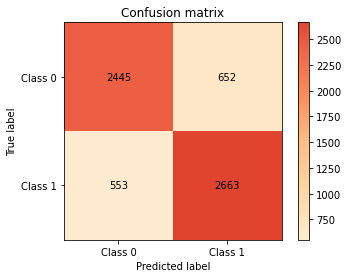

In [318]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf = RandomForestClassifier(max_depth = None, max_features=None, min_samples_leaf=1, n_estimators=100)
clf.fit(X_train, y_train)
  
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation
print('ACCURACY: ', metrics.accuracy_score(y_test, y_pred))
print('PRECISION: ', metrics.precision_score(y_test, y_pred))
print('RECALL: ', metrics.recall_score(y_test, y_pred))
print('F1: ', metrics.f1_score(y_test, y_pred))
plot.confusion_matrix(y_test, y_pred)